In [1]:
#@title Imports & Utils
!pip install -q git+https://www.github.com/google/jax-md

import jax.numpy as jnp
import numpy as onp
from jax import debug
from jax import jit
from jax import grad
from jax import random
from jax import lax
from jax.config import config

config.update('jax_enable_x64', True)
from jax_md import simulate
from jax_md import space
from jax_md import energy
from jax_md import elasticity
from jax_md import quantity
from jax_md import dataclasses
from jax_md.util import f64

# Other libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 

# LAMMPS simulation data for comparison
!wget https://raw.githubusercontent.com/abhijeetgangan/Silicon-data/main/Si-SW-MD/NVE-300K/lammps_nve.dat
!wget https://raw.githubusercontent.com/abhijeetgangan/Silicon-data/main/Si-SW-MD/NVE-300K/step_1.traj
data_lammps = pd.read_csv("lammps_nve.dat", delim_whitespace="  ", header=None)
data_lammps = data_lammps.dropna(axis=1)
data_lammps.columns = ['Time','T','P','V','E','H']
t_l, T, P, V, E, H = data_lammps['Time'], data_lammps['T'], data_lammps['P'], data_lammps['V'], data_lammps['E'], data_lammps['H']

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Using units in JAX-MD (NVE simulation)

This notebook demonstrates the use of a unit system (metal units) for the simulation of the Silicon crystal containing 512 atoms in the NVE ensemble with the Stillinger-Weber potential. This notebook use lammps velocities and positions as a starting point for the simulation and for comparison.

More about the unit system https://docs.lammps.org/units.html

## Load LAMMPS positions and velocities.

In [2]:
lammps_step_0 = onp.loadtxt('/content/step_1.traj', dtype=f64)

In [3]:
# Load positions from lammps
positions = jnp.array(lammps_step_0[:,2:5], dtype=f64)
# Load velocities from lammps
velocity = jnp.array(lammps_step_0[:,5:8], dtype=f64)
latvec = jnp.array([[21.724, 0.000000, 0.000000], [0.00000, 21.724, 0.00000],[0.00000, 0.0000, 21.724]])

## Units and simulation parameters


In [4]:
# Import unit system
from jax_md import units

# Metal units
unit = units.metal_unit_system()

In [5]:
# Simulation parameters
timestep = 1e-3
fs = timestep * unit['time']
ps = unit['time']
dt = fs
write_every = 100
box = latvec
T_init = 300 * unit['temperature']
Mass = 28.0855 * unit['mass']
key = random.PRNGKey(121)
steps = 50000

In [6]:
# Logger to save data
log = {
'E': jnp.zeros((steps // write_every,)),
'P': jnp.zeros((steps // write_every,)),
'T': jnp.zeros((steps // write_every,)),
'kT': jnp.zeros((steps // write_every,)),
}

## Simulation setup

In [7]:
# Setup the periodic boundary conditions. 
displacement, shift = space.periodic_general(latvec) 
dist_fun = space.metric(displacement) 
neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec, disable_cell_list=True)
energy_fn = jit(energy_fn)

In [8]:
# Extra capacity to prevent overflow
nbrs = neighbor_fn.allocate(positions, box=box, extra_capacity=2)

# NVE simulation
init_fn, apply_fn = simulate.nve(energy_fn, shift, dt=dt)
apply_fn = jit(apply_fn)
state = init_fn(key, positions, box=box, neighbor=nbrs, kT=T_init, mass=Mass)

# Restart from LAMMPS velocities
state = dataclasses.replace(state, momentum = Mass * velocity * unit['velocity'])

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


## NVE simulation

In [9]:
@jit
def step_fn(i, state_nbrs):  
  state, nbrs = state_nbrs
  # Take a simulation step.
  t = i * dt
  state = apply_fn(state, neighbor=nbrs)
  nbrs = nbrs.update(state.position, neighbor=nbrs)
  return state, nbrs
    
@jit
def outer_sim_fn(j, state_nbrs_log):
  state, nbrs, log = state_nbrs_log

  # Quantities to calculate
  K  = quantity.kinetic_energy(momentum = state.momentum, mass=Mass)
  E  = energy_fn(state.position, box=box, neighbor=nbrs)
  kT = quantity.temperature(momentum = state.momentum, mass=Mass)
  P  = quantity.pressure(energy_fn, state.position, box, K, neighbor=nbrs)

  # Save the quantities
  log['T'] = log['T'].at[j].set(K + E)
  log['E'] = log['E'].at[j].set(E)
  log['kT'] = log['kT'].at[j].set(kT)
  log['P'] = log['P'].at[j].set(P)

  # Print the quantities
  debug.print('Step = {j} | Total Energy = {T}', j=j*write_every, T=K+E)

  @jit
  def inner_sim_fn(i, state_nbrs):
    return step_fn(i, state_nbrs)
      
  state, nbrs = lax.fori_loop(0, write_every, inner_sim_fn, (state, nbrs))

  return state, nbrs, log

In [10]:
state_r, nbrs_r, log_r = lax.fori_loop(0, int(steps/write_every), outer_sim_fn, (state, nbrs, log))

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Step = 0 | Total Energy = -2200.4826561382047
Step = 100 | Total Energy = -2200.46425361738
Step = 200 | Total Energy = -2200.4632203518713
Step = 300 | Total Energy = -2200.4673715115377
Step = 400 | Total Energy = -2200.4657508762048
Step = 500 | Total Energy = -2200.4681440313525
Step = 600 | Total Energy = -2200.4680987055954
Step = 700 | Total Energy = -2200.463647099563
Step = 800 | Total Energy = -2200.468756595796
Step = 900 | Total Energy = -2200.4663632714096
Step = 1000 | Total Energy = -2200.46447618266
Step = 1100 | Total Energy = -2200.4686575463097
Step = 1200 | Total Energy = -2200.4684029499917
Step = 1300 | Total Energy = -2200.4664806312667
Step = 1400 | Total Energy = -2200.467119464217
Step = 1500 | Total Energy = -2200.4673163162483
Step = 1600 | Total Energy = -2200.4668780623438
Step = 1700 | Total Energy = -2200.469516909134
Step = 1800 | Total Energy = -2200.4682528296357
Step = 1900 | Total Energy = -2200.4650060136287
Step = 2000 | Total Energy = -2200.46770

In [11]:
# Check if neighbors overflowed
print(nbrs_r.did_buffer_overflow)

0


## Comparison plot

Note that you have to reconvert the units again.

In [12]:
Nsteps = int(steps/write_every)
t = jnp.arange(0, Nsteps,dtype=f64) * timestep * write_every

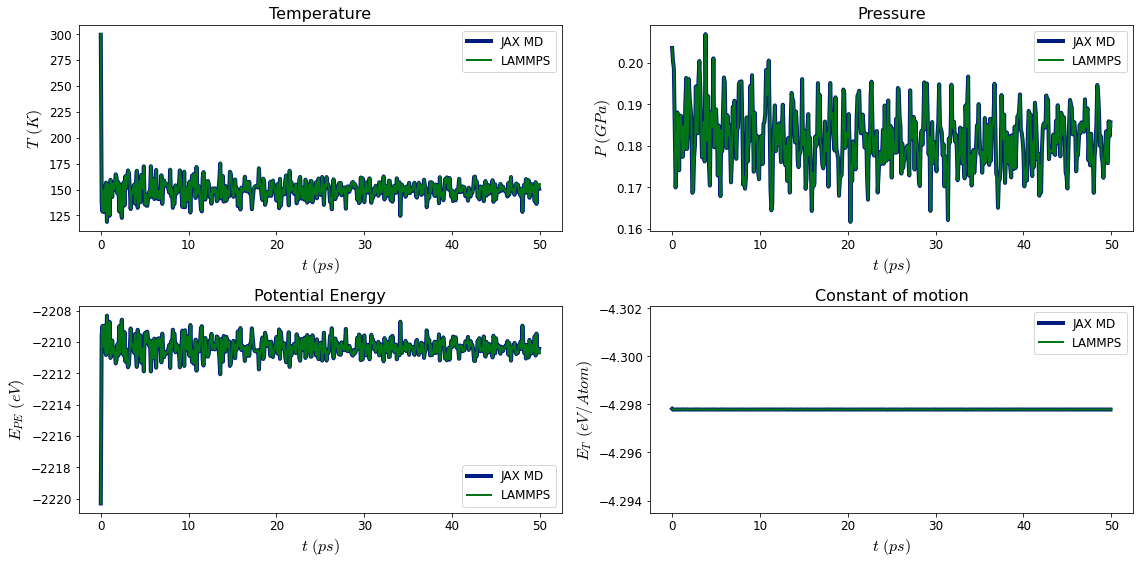

In [13]:
plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(16, 8))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(t, log_r['kT'] / unit['temperature'], lw=4, label='JAX MD')
ax1.plot(t_l, T, lw=2, label='LAMMPS')
ax1.set_title('Temperature', fontsize=16)
ax1.set_ylabel("$T\ (K)$", fontsize=16)
ax1.set_xlabel("$t\ (ps)$", fontsize=16)
ax1.legend()

ax2 = plt.subplot(2, 2, 2)
ax2.plot(t, (log_r['P'] / unit['pressure']) / 10000, lw=4, label='JAX MD')
ax2.plot(t_l, P/10000, lw=2, label='LAMMPS')
ax2.set_title('Pressure', fontsize=16)
ax2.set_ylabel("$P\ (GPa)$", fontsize=16)
ax2.set_xlabel("$t\ (ps)$", fontsize=16)
ax2.legend()

ax3 = plt.subplot(2, 2, 3)
ax3.plot(t, log_r['E'], lw=4, label='JAX MD')
ax3.plot(t_l, E, lw=2, label='LAMMPS')
ax3.set_title('Potential Energy', fontsize=16)
ax3.set_ylabel("$E_{PE}\ (eV)$", fontsize=16)
ax3.set_xlabel("$t\ (ps)$", fontsize=16)
ax3.legend()

ax4 = plt.subplot(2, 2, 4)
ax4.plot(t, log_r['T']/512, lw=4, label='JAX MD')
ax4.plot(t_l, H/512, lw=2, label='LAMMPS')
ax4.set_title('Constant of motion', fontsize=16)
ax4.set_ylabel("$E_{T}\ (eV/Atom)$", fontsize=16)
ax4.set_xlabel("$t\ (ps)$", fontsize=16)
ax4.set_ylim(jnp.mean(log_r['T']/512) - jnp.mean(log_r['T']/512)/1000 , jnp.mean(log_r['T']/512) + jnp.mean(log_r['T']/512)/1000)
ax4.legend()

fig.tight_layout()